# Covariance Matrix Stability in Portfolio Optimization

- Portfolio optimization relies heavily on the covariance matrix of asset returns.
- Instability in the covariance matrix can lead to unreliable portfolio allocation.

We will explore:
- Causes of covariance matrix instability
- Impact on portfolio optimization
- Using condition number as a measure of stability

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display

First, we will define necessary functions to help with our main example. Specifically,
- `get_stock_data` will download adjusted closing prices for selected stock tickers from YahooFinance. It will then convert the prices to returns and remove any missing values.
- `condition_number` Calculates condition number to provide a simple measure of potential instability in portfolio optimisation.
- `optimize_portfolio` performs basic portfolio optimisation for the purpose of this example.
- `plot_portfolio_weights` plots the resultant weights from optimisation.
- `stability_demo` runs the script with the above functions, with some noisy variations to stock returns to showcase the instability in portfolio.

In [26]:
# Function to download stock data
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

# Function to calculate condition number
def condition_number(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.max(np.abs(eigenvalues)) / np.min(np.abs(eigenvalues))

# Function to perform portfolio optimization
def optimize_portfolio(returns, target_return=None):
    mu = returns.mean().values
    Sigma = returns.cov().values
    n = len(mu)
    
    if target_return is None:
        target_return = np.mean(mu)
    
    from scipy.optimize import minimize
    
    def objective(w):
        return np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target_return}
    ]
    
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(objective, np.ones(n) / n, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

# Function to plot portfolio weights
def plot_portfolio_weights(weights, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(weights)), weights)
    plt.title(title)
    plt.xlabel('Asset')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights)), [f'Asset {i+1}' for i in range(len(weights))])
    plt.show()

# Interactive widget to demonstrate stability
def stability_demo(returns):
    Sigma = returns.cov()
    cond_num = condition_number(Sigma)
    
    @widgets.interact(perturbation=widgets.FloatSlider(min=0, max=0.1, step=0.001, value=0))
    def update(perturbation):
        perturbed_returns = returns + np.random.normal(0, perturbation, returns.shape)
        original_weights = optimize_portfolio(returns)
        perturbed_weights = optimize_portfolio(perturbed_returns)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(len(original_weights)), original_weights, alpha=0.5, label='Original')
        plt.bar(range(len(perturbed_weights)), perturbed_weights, alpha=0.5, label='Perturbed')
        plt.title(f'Portfolio Weights (Perturbation: {perturbation:.3f})')
        plt.xlabel('Asset')
        plt.ylabel('Weight')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        weight_diff = np.abs(original_weights - perturbed_weights)
        plt.bar(range(len(weight_diff)), weight_diff)
        plt.title('Absolute Difference in Weights')
        plt.xlabel('Asset')
        plt.ylabel('Absolute Difference')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Condition Number: {cond_num:.2f}")
        print(f"Max Weight Difference: {np.max(weight_diff):.4f}")

## Main execution

The Python code module below demonstrates the concepts discussed in the slides:
- It downloads real stock data using yfinance.
- Calculates the covariance matrix and its condition number.
- Performs portfolio optimization using mean-variance optimization.
- Provides an interactive widget to demonstrate how small perturbations in the return data can lead to significant changes in portfolio weights, especially when the condition number is high.

[*********************100%***********************]  10 of 10 completed


Condition Number of Covariance Matrix: 57.54


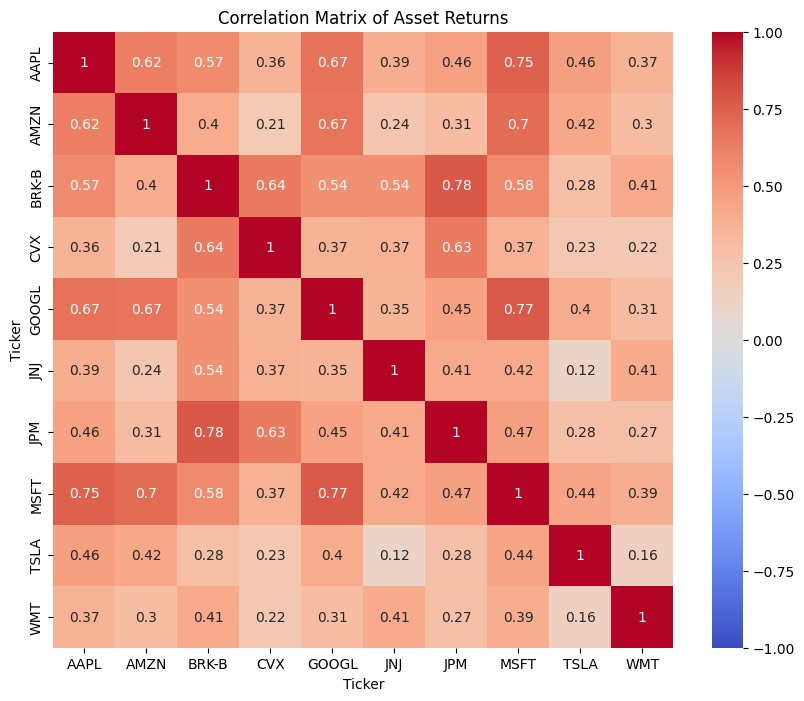

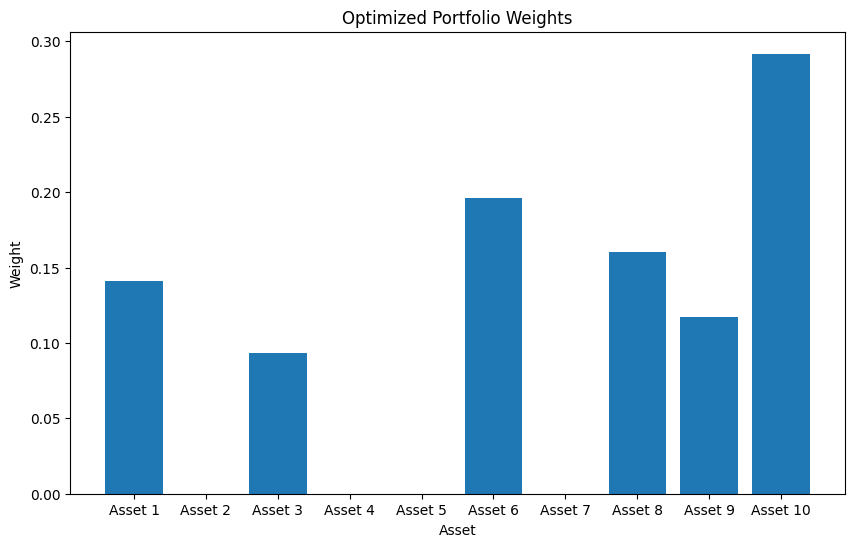

interactive(children=(FloatSlider(value=0.0, description='perturbation', max=0.1, step=0.001), Output()), _dom…

In [29]:
# Download stock data
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'CVX', 'TSLA', 'BRK-B', 'JPM', 'JNJ', 'WMT']
start_date = '2018-01-01'
end_date = '2023-12-31'
returns = get_stock_data(tickers, start_date, end_date)
    
# Calculate and print condition number
Sigma = returns.cov()
cond_num = condition_number(Sigma)
print(f"Condition Number of Covariance Matrix: {cond_num:.2f}")
    
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Asset Returns')
plt.show()
    
# Optimize portfolio
weights = optimize_portfolio(returns)
plot_portfolio_weights(weights, 'Optimized Portfolio Weights')
    
# Run interactive stability demo
stability_demo(returns)